# Brain Cancer Classification With a Quantum Hybrid-Classical Model

## Objectives
Classifying different Brain Cancer Types based on MRI images using a Quantum Hybrid-Classical Model then Comprare the results with a Classical Model (DenseNet121)

## Importing needed libraries

In [693]:
# QML
import pennylane as qml

# CML
import tensorflow as tf
from tensorflow import keras as K

# Timer
from timeit import default_timer as timer
from datetime import timedelta

# for data
import pandas as pd
from os import listdir
from matplotlib import image
from matplotlib import pyplot as plt
import h5py
import umap
import cv2
from sklearn.model_selection import train_test_split

# for evaluation
from sklearn.metrics import classification_report
import itertools

# calculus
from pennylane import numpy as np


## Data Analysis

In this section we are going to introduce the used dataset and do some visualization in order to explore its contents

### About the dataset

The dataset has been downloaded from figshare website [link](https://figshare.com/articles/dataset/brain_tumor_dataset/1512427/5)

It is organized in matlab data format (.mat file). Each file stores a struct
containing the following fields for an image:

    - cjdata.label: 1 for meningioma, 2 for glioma, 3 for pituitary tumor
    - cjdata.PID: patient ID
    - cjdata.image: image data
    - cjdata.tumorBorder: a vector storing the coordinates of discrete points on tumor border.
            - For example, [x1, y1, x2, y2,...] in which x1, y1 are planar coordinates on tumor border.
            - It was generated by manually delineating the tumor border. So we can use it to generate
            - binary image of tumor mask.
    - cjdata.tumorMask: a binary image with 1s indicating tumor region

### Visualize the data

#### Labels

In [999]:
# Counting labels
folder = "../brain_tumor_dataset/all/" # .mat files folder
directs = sorted(listdir(folder))
labels = []
for file in directs:
    f = h5py.File('../brain_tumor_dataset/all/'+file,'r')
    label = np.array(f.get("cjdata/label"))[0][0]
    labels.append(label)
labels = pd.Series(labels)
labels.shape

(3064,)

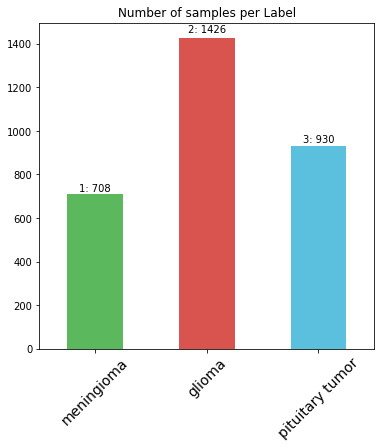

In [1000]:
# Tumor types
names = ["meningioma", "glioma", "pituitary tumor"]
# Count labels
labelcounts = labels.value_counts().sort_index()
# change the index with th types
labelcounts.index = names

#print(labelcounts)

# create a barchart
ax = labelcounts.plot(
        kind='bar',
        figsize=(6, 6),
        width=0.5,
        color=['#5cb85c', '#d9534f', '#5bc0de'],
     )

# define the title
ax.set_title("Number of samples per Label", size=12)
# change font size for labells an legend
plt.xticks(fontsize=14, rotation=45)

# putting the numbers
i = 1
for p in ax.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy()
    ax.annotate(str(i)+": "+str(height), (x + width/2, y + height*1.02), ha='center')
    i += 1


#### Pictures

In [941]:
folder = "../brain_tumor_dataset/all/" # .mat files folder
directs = sorted(listdir(folder))
labels = []
images = []
masks = []
for file in directs:
    f = h5py.File(folder+file,'r')
    label = np.array(f.get("cjdata/label"))[0][0]
    if label not in labels:
        #print(file)
        labels.append(label)
        img = np.stack((np.array(f.get("cjdata/image")),)*4, axis=-1)
        images.append(img)
        mask = np.array(f.get("cjdata/tumorMask"))
        masks.append(mask)
labels = np.asarray(labels)
images = np.asarray(images)
masks = np.asarray(masks)
labels.shape, images.shape, masks.shape

((3,), (3, 512, 512, 4), (3, 512, 512))

In [952]:
b = K.utils.to_categorical(masks, num_classes=4).astype(np.uint8)
tumor = np.zeros_like(images[:, :, :, 1:])
image_norm = cv2.normalize(images[:, :, :, 0], None, alpha=0, beta=255,
                      norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F).astype(np.uint8)

print(image_norm.shape)

# remove tumor part from image
tumor[:, :, :, 0] = image_norm * (b[:, :, :, 0])
tumor[:, :, :, 1] = image_norm * (b[:, :, :, 0])
tumor[:, :, :, 2] = image_norm * (b[:, :, :, 0])

# color tumor
tumor += b[:, :, :, 1:] * 255

tumor.shape

(3, 512, 512)


(3, 512, 512, 3)

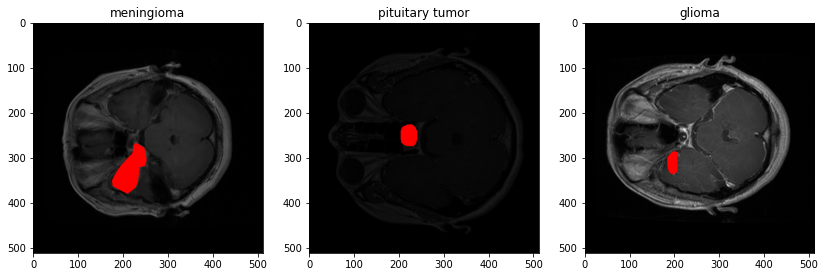

In [951]:
fig = plt.figure(figsize=(14, 10))
for i in range(3):
    fig.add_subplot(1, 3, i+1)
    plt.imshow(tumor[i], "gray")
    plt.title(names[int(labels[i]-1)])

plt.show()

# Model

In this section we will talk about our model and how we designed it

## Architecture

Based on classical Convolutional Neural Network Architecture (fig. 1) and pure Quantum Convolutional Neural Network (fig. 2) we came out with the Quantum Hybrid-Classical presented in the (fig. 3)
<fieldset style="text-align=center">
<legend>Fig. 1: Simple Convolutional Neural Network</legend>

<p><img src="CNN.png" alt="CNN" width="100%"></p>

</fieldset>
<br>

<fieldset style="text-align=center">

<legend>Fig. 2: Quantum Convolutional Neural Network</legend>

<p ><img src="QCNN.png" alt="QCNN" width="100%"></p>

</fieldset>
<br>
<fieldset style="text-align=center">

<legend>Fig. 3: Our Quantum Hybrid-Classical Convolutional Neural Network</legend>

<p><img src="model.jpg" alt="Model" width="100%"></p>


</fieldset>


Resources

<hr>

[1 researchgate](https://www.researchgate.net/publication/331540139_A_State-of-the-Art_Survey_on_Deep_Learning_Theory_and_Architectures/figures?lo=1&utm_source=google&utm_medium=organic)
<br>
[1 arxiv](https://arxiv.org/pdf/2009.09423.pdf)
<br>
[1 pennylane](https://pennylane.ai/qml/demos/tutorial_quanvolution.html?fbclid=IwAR3Sw-OvDokiY1bzltvyyLHnnlPvlVTnAiwH3HqjTYpLxnjSbibGBfaSmTA)

## Image processing

#### First part: Features Extraction

<hr>
Defining Quantum Circuit and Quantum Convolutional function

In [960]:
wires=4

dev4 = qml.device("default.qubit", wires=wires)  # define the simulator
@qml.qnode(dev4)
def CONVCircuit(phi, wires, i=0):
    """
    quantum convolution Node
    """
    # parameter
    theta = np.pi / 2

    qml.RX(phi[0] * np.pi, wires=0)
    qml.RX(phi[1] * np.pi, wires=1)
    qml.RX(phi[2] * np.pi, wires=2)
    qml.RX(phi[3] * np.pi, wires=3)

    qml.CRZ(theta, wires=[1, 0])
    qml.CRZ(theta, wires=[3, 2])
    qml.CRX(theta, wires=[1, 0])
    qml.CRX(theta, wires=[3, 2])
    qml.CRZ(theta, wires=[2, 0])
    qml.CRX(theta, wires=[2, 0])

    # Expectation value
    measurement = qml.expval(qml.PauliZ(wires=0))

    return measurement


def QCONV1(X, image_number, image_total, step=2):
    """
    quantum convolutional layer
    """

    #H, W, CH = X.shape
    H, W = X.shape
    step2 = 4
    out = np.zeros((H//step, W//step))
    #progress = 0
    for i in range(0, W, step):
        #print("processing image "+str(image_number)+"/ "+str(image_total)+": "+str(int(((i/W+1))*100))+"% ", end="\r")
        print("processing image "+str(image_number)+"/ "+str(image_total)+": "+str(i)+"px   ", end="\r")
        for j in range(0, H, step):
            # average pooling of each 4x4 pixels
            px0 = X[i:i+step2, j:j+step2].mean()
            px1 = X[i:i+step2, j+step2:j+step].mean()
            px2 = X[i+step2:i+step, j:j+step2].mean()
            px3 = X[i+step2:i+step, j+step2:j+step].mean()

            phi = np.array([px0, px1, px2, px3])

            # Get Measurement
            measurement = CONVCircuit(phi, len(phi))
            out[i//step, j//step] = measurement

    return out


<hr>
Visualizing Quantum Circuit

In [961]:
phi = [1, 1, 1, 1]
drawer = qml.draw(CONVCircuit)
print(drawer(phi, 4))

 0: ──RX(3.14)──╭RZ(1.57)──╭RX(1.57)──╭RZ(1.57)──╭RX(1.57)──┤ ⟨Z⟩ 
 1: ──RX(3.14)──╰C─────────╰C─────────│──────────│──────────┤     
 2: ──RX(3.14)──╭RZ(1.57)──╭RX(1.57)──╰C─────────╰C─────────┤     
 3: ──RX(3.14)──╰C─────────╰C───────────────────────────────┤     



<hr>

Applying the Quantum Convolutional Layer

In [964]:
# Images processing with a Quantum Convolutional Layer
folder = "../brain_tumor_dataset/all/" # .mat files folder

start = timer()
w = 512
step = 8
k = 0
directs = sorted(listdir(folder))
all64 = sorted(listdir("../brain_tumor_dataset/processed/all/"))
for file in directs:
    if file+".npz" in all64:
        continue
    f = h5py.File(folder+file, 'r')
    image = np.array(f.get("cjdata/image"))
    if image.shape[0] < 512:
        continue
    label = np.array(f.get("cjdata/label"))[0][0]
    NorImages = image/255
    processed = QCONV1(NorImages, str(k)+" "+file, len(directs), step)

    np.savez_compressed("../brain_tumor_dataset/processed/all/"+file, image=processed, label=label)
    k+=1
end = timer()
time = (end - start)
str(timedelta(seconds=round(time)))

'0:00:00'

<hr>
Visualization after applying quantum filter

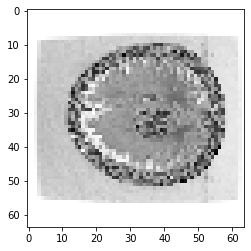

In [965]:
img = np.load("../brain_tumor_dataset/processed/all/10.mat.npz")['image']
plt.imshow(img, "gray")
plt.show()


#### The second part: Classification

<hr>
Get processed images coupled with their labels

In [970]:
# get processed data
folder = "../brain_tumor_dataset/processed/all/"
directs = sorted(listdir(folder))

images = []
masks = []
labels = []
i = 0
for file in directs:
    data = np.load(folder+file)
    images.append(data["image"])
    labels.append(data["label"])
    i+=1

npimages = np.stack((images,), axis=-1)
nplabels = np.asarray(labels)

In [971]:
npimages.shape, nplabels.shape#, npmasks.shape

((3049, 64, 64, 1), (3049,))

<hr>

Splitting the data to 3 parts train/validation/test

In [972]:

X_train, X_test, y_train, y_test = train_test_split(npimages, nplabels,
                                                    test_size=0.3,
                                                    random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(X_test, y_test,
                                                    test_size=0.5,
                                                    random_state=42)

In [973]:
X_train.shape, X_test.shape, X_valid.shape, y_valid.shape, y_train.shape, y_test.shape

((2134, 64, 64, 1),
 (458, 64, 64, 1),
 (457, 64, 64, 1),
 (457,),
 (2134,),
 (458,))

<hr>

Defining Fully Connected Layers with Tensorflow

In [976]:
def Model():
    """
    Fully Connected Layer
    """
    model = K.models.Sequential([
        K.layers.Flatten(),
        K.layers.Dense(128, activation="relu"),
        K.layers.Dropout(0.5),
        #K.layers.Dense(32, activation="relu"),
        #K.layers.Dropout(0.5),
        K.layers.Dense(4, activation="softmax")
    ])
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model

<hr>

Train the model

In [991]:
### tf.random.set_seed(42)
q_model = Model()
"""checkpoint_path = "checkpoints/quantum.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)"""

q_history = q_model.fit(
    X_train,
    y_train,
    validation_data=(X_valid, y_valid),
    batch_size=16,
    epochs=50,
    verbose=2,
    #callbacks=[cp_callback]
)

Epoch 1/50
134/134 - 1s - loss: 0.9512 - accuracy: 0.5750 - val_loss: 0.6251 - val_accuracy: 0.7177
Epoch 2/50
134/134 - 1s - loss: 0.6285 - accuracy: 0.7245 - val_loss: 0.5031 - val_accuracy: 0.8031
Epoch 3/50
134/134 - 1s - loss: 0.5196 - accuracy: 0.7882 - val_loss: 0.4599 - val_accuracy: 0.8162
Epoch 4/50
134/134 - 1s - loss: 0.4251 - accuracy: 0.8271 - val_loss: 0.4237 - val_accuracy: 0.8271
Epoch 5/50
134/134 - 1s - loss: 0.4029 - accuracy: 0.8449 - val_loss: 0.4175 - val_accuracy: 0.8162
Epoch 6/50
134/134 - 1s - loss: 0.3639 - accuracy: 0.8580 - val_loss: 0.3886 - val_accuracy: 0.8271
Epoch 7/50
134/134 - 1s - loss: 0.3136 - accuracy: 0.8744 - val_loss: 0.4005 - val_accuracy: 0.8162
Epoch 8/50
134/134 - 1s - loss: 0.2886 - accuracy: 0.8927 - val_loss: 0.3754 - val_accuracy: 0.8643
Epoch 9/50
134/134 - 1s - loss: 0.2551 - accuracy: 0.9105 - val_loss: 0.3413 - val_accuracy: 0.8796
Epoch 10/50
134/134 - 1s - loss: 0.2475 - accuracy: 0.9142 - val_loss: 0.3263 - val_accuracy: 0.8425

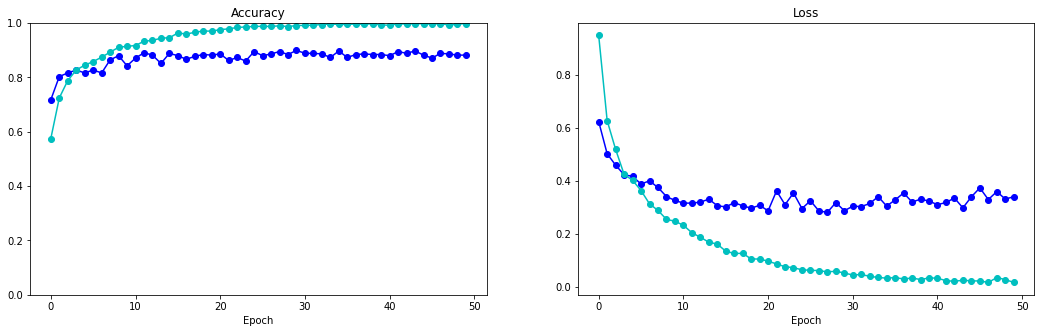

In [992]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 5))
ax1.plot(q_history.history["val_accuracy"], "-ob")
ax1.plot(q_history.history["accuracy"], "-oc")
ax1.set_ylim([0, 1])
ax1.set_title("Accuracy")
ax1.set_xlabel("Epoch")

ax2.plot(q_history.history["val_loss"], "-ob")
ax2.plot(q_history.history["loss"], "-oc")
ax2.set_title("Loss")
ax2.set_xlabel("Epoch")
plt.show()

## Evaluation
<hr>

Defining a method to plot the Confusion Matrix

In [993]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

<hr>
Get predicted labels

In [994]:
yhat = q_model.predict(X_test)
yhat = yhat.argmax(axis=1)

In [995]:
yhat.shape, y_test.shape

((458,), (458,))

In [996]:
# printing classification report
print(classification_report(y_test, yhat))


              precision    recall  f1-score   support

         1.0       0.83      0.76      0.79       113
         2.0       0.90      0.90      0.90       213
         3.0       0.93      0.98      0.96       132

    accuracy                           0.89       458
   macro avg       0.88      0.88      0.88       458
weighted avg       0.89      0.89      0.89       458



Confusion matrix, without normalization


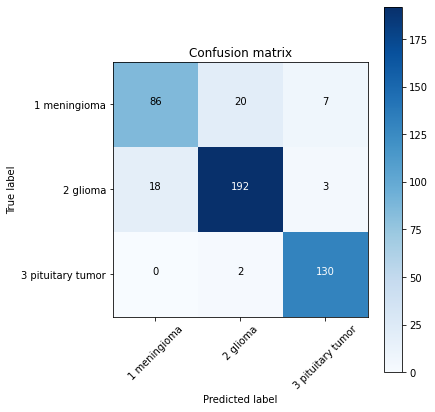

In [997]:
# Compute confusion matrix
cnf_matrix = tf.math.confusion_matrix(y_test, yhat)
np.set_printoptions(precision=2)
# Plot non-normalized confusion matrix
plt.figure(figsize=(6, 6))
plot_confusion_matrix(np.array(cnf_matrix[1:, 1:]), classes=['1 meningioma', '2 glioma', '3 pituitary tumor'], normalize=False,  title='Confusion matrix')

# Classical

In [2]:
# Images resizing
folder = "../brain_tumor_dataset/all/" # .mat files folder

w = 512
step = 8
k = 0
directs = sorted(listdir(folder))
images = []
labels = []

for file in directs:

    f = h5py.File(folder+file, 'r')
    img = np.array(f.get("cjdata/image"))
    if img.shape[0] < 512:
        continue
    label = np.array(f.get("cjdata/label"))[0][0]
    scale_percent = 40 # percent of original size
    width = int(img.shape[1] * scale_percent / 100)
    height = int(img.shape[0] * scale_percent / 100)
    dim = (width, height)

    # resize image
    resized = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
    images.append(np.stack((resized,)*3, axis=-1)/255)
    labels.append(label)
    #NorImages = image/255
    
    if k > 1000:
        break
    k+=1
cimages = np.asarray(images)
clabels = np.asarray(labels)

In [3]:
# Make a train/test split using 30% test size
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(cimages, clabels,
                                                    test_size=0.3,
                                                    random_state=42)

In [4]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((701, 204, 204, 3), (301, 204, 204, 3), (701,), (301,))

In [ ]:
num_classes = 4
input_shape = X_train.shape[0]
model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=input_shape),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])
model.compile(
        optimizer=K.optimizers.Adam(),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
)

history = model.fit(
    X_train,
    y_train,
    validation_data=(X_test, y_test),
    batch_size=16,
    epochs=3,
    verbose=1,
)

In [ ]:
model.compile(
        optimizer=K.optimizers.Adam(),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
)
checkpoint_path = "checkpoints/classical.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)
history = model.fit(
    X_train,
    y_train,
    validation_data=(X_test, y_test),
    batch_size=16,
    epochs=3,
    verbose=1,
    callbacks=[cp_callback]
)

In [ ]:
model = K.applications.DenseNet121(
    include_top=True,
    weights=None, #"imagenet",
    input_tensor=None,
    input_shape=(204, 204, 3),
    pooling=None,
    classes=4,
)
model.compile(
        optimizer=K.optimizers.Adam(),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
)
history = model.fit(
    X_train,
    y_train,
    validation_data=(X_test, y_test),
    batch_size=16,
    epochs=3,
    verbose=1,
)

Epoch 1/3
44/44 [==============================] - 924s 21s/step - loss: 0.7733 - accuracy: 0.7576 - val_loss: 212.6744 - val_accuracy: 0.4551
Epoch 2/3
 7/44 [===>..........................] - ETA: 1:19:54 - loss: 0.1104 - accuracy: 0.9663ETA: 7:17:11 - loss: 0.0686 - accuracy: 1.000 - ETA: 3:44:39 - loss: 0.0683 - accuracy: 0.993 - ETA: 2:33:27 - loss: 0.0819 - accuracy: 0.983 - ETA: 1:56:55 - loss: 0.0967 - accuracy: 0.97

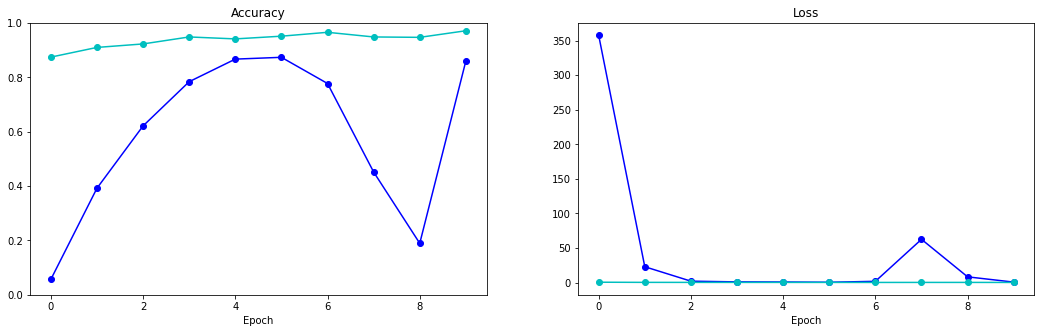

In [23]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 5))
ax1.plot(history.history["val_accuracy"], "-ob", label='Training Accuracy')
ax1.plot(history.history["accuracy"], "-oc", label='Training Accuracy')
ax1.set_ylim([0, 1])
ax1.set_title("Accuracy")
ax1.set_xlabel("Epoch")

ax2.plot(history.history["val_loss"], "-ob")
ax2.plot(history.history["loss"], "-oc")
ax2.set_title("Loss")
ax2.set_xlabel("Epoch")
plt.show()

In [26]:
yhat = model.predict(X_test)
yhat = yhat.argmax(axis=1)

In [30]:
# Compute confusion matrix
cnf_matrix = tf.math.confusion_matrix(y_test, yhat)
np.set_printoptions(precision=2)

print(classification_report(y_test, yhat))

              precision    recall  f1-score   support

         1.0       0.34      1.00      0.51        22
         2.0       1.00      0.53      0.69        17
         3.0       1.00      0.87      0.93       262

    accuracy                           0.86       301
   macro avg       0.78      0.80      0.71       301
weighted avg       0.95      0.86      0.89       301



Confusion matrix, without normalization


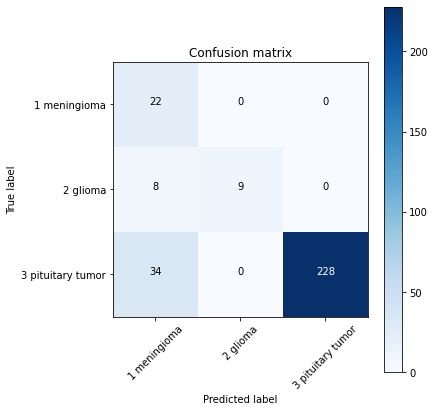

In [31]:
# Plot non-normalized confusion matrix
plt.figure(figsize=(6, 6))
plot_confusion_matrix(np.array(cnf_matrix[1:, 1:]), classes=['1 meningioma', '2 glioma', '3 pituitary tumor'], normalize=False,  title='Confusion matrix')